# Pytorch starter - FasterRCNN Train
In this notebook I enabled the GPU and the Internet access (needed for the pre-trained weights). We can not use Internet during inference, so I'll create another notebook for commiting. Stay tuned!

You can find the [inference notebook here](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-inference)

- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)


### Imports

In [1]:
import pandas as pd # Pandas DF
import numpy as np # matrix operations
import cv2 # image read
import os # file listing
import re # regex!
import time # time measures (model training)
import shutil # Shell Scripts package in Python


from PIL import Image # image
from skimage import io # skimage is the utils packe for image in PyTorch
from sklearn.model_selection import train_test_split # train test split

### Data Augmentations
from albumentations.pytorch import ToTensor# Data augmentations old NB
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)# Data augmentations old NB
import albumentations as A # Data augmentations
from albumentations.pytorch.transforms import ToTensorV2 # Data Augmentations

# PyTorch
import torch 
import torchvision

# Models from torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn # NN in PyTorch
import torchvision.transforms as T # Trasnformers for PyTorch
from torchvision import datasets, transforms


# DataLoader, DataSet
from torch.utils.data import DataLoader, Dataset
from torchvision import utils
from torch.utils.data.sampler import SequentialSampler

# Graphs
from matplotlib import pyplot as plt


# Sources
DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

# device pytorch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
### This DF is train_df in the competition, however here it will be used to process 2 DFs - one for the training part, the other for validation part
df = pd.read_csv(f'{DIR_INPUT}/train.csv')
print(df.shape)
df.iloc[0]

(147793, 5)


image_id                     b6ab77fd7
width                             1024
height                            1024
bbox        [834.0, 222.0, 56.0, 36.0]
source                         usask_1
Name: 0, dtype: object

### Utils Methods
1. image convert - converts an image to W,H,C structure
2. plot image - takes a data, its index and gets the image for plotting purposes
3. get trasforms - gets mean, std, and phase (train / test) and generate list of transformers accordingly.
4. calc mean std - calculates mean, std of a dataset
5. process bbox - processes a bounding box (one of the columns in the dataset)
6. expand bbox - expand the bbox array column to be in 4 different columns (x, y, w, h)

In [3]:
def image_convert(image):
    """ This function takes an image as input and converts it into the W,H,C structure"""
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0)) # H, W, C --->3x24x24 ---> 24x24x3
    image = (image * 255).astype(np.uint8) ### Why is this astype needed?
    return image

def plot_img(data,idx):
    """ This function takes an data, idx, gets the image out of it and plots the image"""
    out = data.__getitem__(idx)
    image = image_convert(out[0]) ### the X / image from data
    image = np.ascontiguousarray(image) # Return a contiguous array (ndim >= 1) in memory (C order).
    print("The shape of this image is:", image.shape)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    

def get_transforms(mean,std, phase):
    """ This method gets a mean, std, and phase parameter (phase is phase of model - train / test) and generates a list of transforms onto it"""
    list_transforms = []
    if phase == 'train':
        list_transforms.extend([Flip(p=0.5)])
    list_transforms.extend([ToTensor(),])
    # T.Normalize(mean=mean, std=std)]
                                  
            
    list_trfms = Compose(list_transforms, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

    return list_trfms


# Should run in GPU mode
def calc_mean_std(data_path):
## '/kaggle/input/global-wheat-detection'
    dataset = datasets.ImageFolder(data_path, transform=transforms.ToTensor()) ### this call returns an ImageFolder object of PyTorch
    
    sum_var = 0
    countel_var = 0
    sumel = 0.0
    countel = 0
    
    for img, _ in dataset:
        
        ### Mean Calculation
        # Then, we just sum all pixels in the images
        sumel += img.sum([1, 2])
        
        countel += torch.numel(img[0])
    mean = sumel/countel

    
    for img, _ in dataset:
        ### STD calculation
        # First, calculate variance for each image
        img_var = (img - mean.unsqueeze(1).unsqueeze(1))**2
        # Then, calculate sum of variance
        sum_var += img_var.sum([1, 2])
        # Then, calculate the count of the var
        countel_var += torch.numel(img_var[0])
    std = torch.sqrt(sum_var/countel_var)
    
    return (mean, std)


def process_bbox(df):
    """ This method enriches a DF with x, y, h, w coordinates, in order to deprecate the bbox column"""
    # first, create columns with dummy values
    df['x'] = -1
    df['y'] = -1
    df['w'] = -1
    df['h'] = -1
    
    df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x: expand_bbox(x)))
    df.drop(columns=['bbox'], inplace=True)
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)
    
    return df


""" This method gets some x and expands it to bbox"""
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x)) # range of digits between 0-9, anything but letters (.), one or more digits like this , that occurs one or more (?), 
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r



# preprocess - covert list bbox to df coulmns

In [4]:
df = process_bbox(df) ### This command will generate a columns of x, y, w, h instead of bbox

In [5]:
df.iloc[0]

image_id    b6ab77fd7
width            1024
height           1024
source        usask_1
x                 834
y                 222
w                  56
h                  36
Name: 0, dtype: object

# EDA (Exploratory Data Analysis)

,num_bbox
count,3373.000000
mean,43.816484
std,20.374820
min,1.000000
25%,28.000000
50%,43.000000
75%,59.000000
max,116.000000


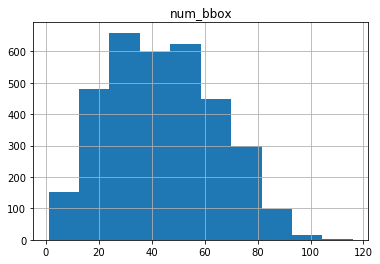

In [6]:
### Group the data by imageId
#Note: This dataframe refers to only images with bounding box
df_bbox_images=df.groupby("image_id").x.count().rename('num_bbox').reset_index()
df_bbox_images.hist()
df_bbox_images.describe()

Looking at the bbox dist:

mean and median are equal points for normal distribtuion, we'll see it in a bit
std is not too larege or small, meaning the data is pretty much centralized.
TODO: still would like to look at the top 10 percentile of the distribution to decide if we want to define outliers (max 116)

### Train Validation Split

In [7]:
image_ids = df['image_id'].unique() # get unique image ids

train_ids, valid_ids, _, _ = train_test_split(image_ids, image_ids, test_size=0.2, random_state=42)

train_df = df[df['image_id'].isin(train_ids)]
valid_df = df[df['image_id'].isin(valid_ids)]

print("train labels:", train_df.shape, 'train images count', len(train_ids))
print("valid labels:", valid_df.shape, 'valid images count', len(valid_ids))

train labels: (118371, 8) train images count 2698
valid labels: (29422, 8) valid images count 675


### DataSet class

In [8]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ### Calculate Area - H * W of bbox using numpy operations - doing it vectorwise
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int: ### TODO: investigate about -> in Python
        return self.image_ids.shape[0]

In [9]:
# Albumentations - note the Albumentations are for train and test, separately. 
# test contains only ToTensorV2
### ToTensor - Convert image and mask to torch.Tensor and divide by 255 if image or mask are uint8 type.
### ToTensorV2 - Convert image and mask to torch.Tensor.
### Source: https://albumentations.readthedocs.io/en/latest/api/pytorch.html

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

In [10]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


### Transfer learning on the pretrained model

In [11]:
num_classes = 2  # 1 class (wheat) + background --- this is relevant for each and every pixel in the image.

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

print("Before model replacement", model.roi_heads.box_predictor)
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print("New model head size", in_features, num_classes)
### per each class (0 / 1) - get also predictions of the bbox out of it.

Before model replacement FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)
New model head size 1024 2


### Class Averager - calculating avg. loss of iterations in an epoch

In [12]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


### Instantiate DataSet + DataLoader objects

In [13]:
def collate_fn(batch):
    ### https://discuss.pytorch.org/t/how-to-use-collate-fn/27181/3
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
# indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

# Sample - Every iteration is one minibatch of 16 (because using train_data_loader)

In [14]:
images, targets, image_ids = next(iter(train_data_loader))
#print(images, targets, image_ids )
images = list(image.to(device) for image in images)
print(len(images))
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
print(len(targets))

16
16


In [15]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Let's show one image before training

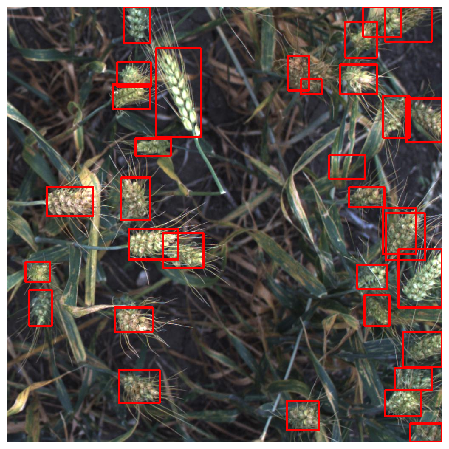

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [17]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 5

In [18]:
loss_hist = Averager()
itr = 1

## Running on num epochs parameter
for epoch in range(num_epochs):
    loss_hist.reset()
    
    ### Each iteration is in size mini_batch examples (in this case 16)
    ### Once iteration had ended, itr will increase by 1.
    ### For each iteration (mini batch), we are calculating the loss, and at the end of each epoch - calculating the avg. loss using the Averager class.
    ### (Avg. - AVG )
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        ### Forward pass on pretrained model
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        
        ### Zero Gradinets
        optimizer.zero_grad()
        
        ### Update weights
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    ### This is the average loss of an epoch (based on the iteration's losses)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

Iteration #50 loss: 0.9288526773452759
Iteration #100 loss: 0.6339471340179443
Iteration #150 loss: 0.4916815459728241
Epoch #0 loss: 0.8445136966789968
Iteration #200 loss: 0.7700338363647461
Iteration #250 loss: 0.7366877794265747
Iteration #300 loss: 0.756680428981781
Epoch #1 loss: 0.7233614561825814
Iteration #350 loss: 0.9995560050010681
Iteration #400 loss: 0.7028646469116211
Iteration #450 loss: 0.7099490761756897
Iteration #500 loss: 0.7353999614715576
Epoch #2 loss: 0.7017045761706561
Iteration #550 loss: 0.7550908923149109
Iteration #600 loss: 0.652346670627594
Iteration #650 loss: 0.510589063167572
Epoch #3 loss: 0.684700502093727
Iteration #700 loss: 0.7093073725700378
Iteration #750 loss: 0.8361731767654419
Iteration #800 loss: 0.6845560669898987
Epoch #4 loss: 0.6751317002716855


In [19]:
images, targets, image_ids = next(iter(valid_data_loader))

In [20]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [21]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [22]:
model.eval() ### We are going to predict from now on

cpu_device = torch.device("cpu")

#### Forward pass on the validation dataset
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

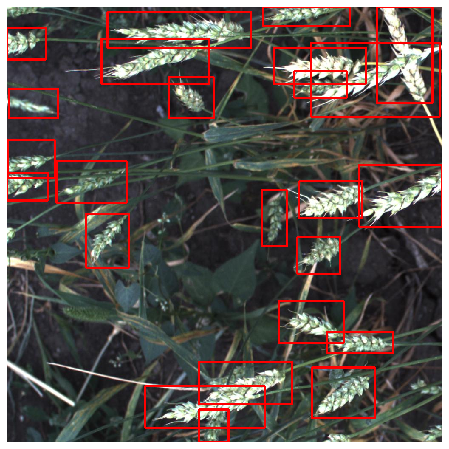

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
### This is ground truth of the image - this is not the prediction
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

### Model Saving

In [24]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')
### TODO: Save model and load model in ONNX